<a href="https://colab.research.google.com/github/moanesga/moanesga-RSNA-Monai-3D_Classification_Brain_Tumor/blob/main/RSNA_Monai_3D_Classification_Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anerkennungen

*   https://www.kaggle.com/code/rinnqd/monai-simple-prediction-from-flair
*   https://www.kaggle.com/code/mikecho/rsna-miccai-monai-ensemble



Relevanz

*   Glioblastoma -> Maligner Tumor, häufigster Hirntumor bei Erwachsenen. Überlebensraten von weniger als einem Jahr.
*   Radiogenomics-> Vorhersage der Genetik des Krebses durch bildgebende Verfahren, die weniger invasiv als eine Operation sind und die Art der erforderlichen Therapie verbessern.  
*   Goal-> Vorhersage des genetischen Subtyps des Glioblastoms anhand von MRT-Scans zum Nachweis einer MGMT-Promotor-Methylierung

In [1]:
#installing
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.2 MB/s eta 0:00:00


In [2]:
!pip install pydicom==2.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.0 MB/s eta 0:00:00


In [3]:
import os
import sys
import json
import glob
import random
import re
import collections
import time

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


In [4]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [5]:
data_path = kagglehub.competition_download('rsna-miccai-brain-tumor-radiogenomic-classification')
print('DB import complete.')

100%|██████████| 12.3G/12.3G [10:23<00:00, 21.2MB/s]

Extracting files...


DB import complete.


In [6]:
data_directory = "/root/.cache/kagglehub/competitions/rsna-miccai-brain-tumor-radiogenomic-classification"
for files in os.listdir(data_path):
    print(files)

test
train_labels.csv
sample_submission.csv
train


In [ ]:
# check this monai_path = "/root"

In [7]:
#Config hyperparameters

mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
SIZE = 256. # Image size
NUM_IMAGES = 64 #3D images per case
BATCH_SIZE = 4 # presumably for training & test
N_EPOCHS = 16 #Try 15
SEED = 12345
LEARNING_RATE = 0.0005
LR_DECAY = 0.9

#n_workers = 4
#do_valid = True

In [35]:
# Load images functions

import numpy as np
import pydicom
import cv2
import glob
import re

def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array # Produces a NumPy arrray that stores the pixel data, the actual image content
    if np.min(data)==np.max(data): # Returns zero-filled array for not useful images
        data = np.zeros((int(img_size),int(img_size)))
        return data

    data = cv2.resize(data, (int(img_size), int(img_size))) #Resizing the image to 256 pixels
    return data


#The DICOM files are often named with numerical indices, and natural_sort helps in maintaining their proper sequence.
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

#Stacking 3D images
#Only FLAIR mri_type is being selected
def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    files = natural_sort(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"))

    every_nth = len(files) / num_imgs # Interval at which to select files, to reduce number of images loaded
    indexes = [min(int(round(i*every_nth)), len(files)-1) for i in range(0,num_imgs)] # Index not exceeding total of files

    #Change back to this if problems: files_to_load = [files[i] for i in indexes] #Loading only selected

    files_to_load = []
    for i in indexes:
        try:
            files_to_load.append(files[i])
        except IndexError:
            print(f"Warning: Index {i} out of range for files list (length: {len(files)})")
            # Handle the error appropriately (e.g., skip the index or raise a custom exception)

    #Core of 3D image construction
    #Load each DICOM file and stack the 2D image along a new axis usign np.stack.
    #T transposes the array to a 3D image
    img3d = np.stack([load_dicom_image(f) for f in files_to_load]).T

    #Normalization, scaling pixel values to a range between 0 and 1, improve performance of ML model.
    img3d = img3d - np.min(img3d)
    if np.max(img3d) != 0:
        img3d = img3d / np.max(img3d)

    return np.expand_dims(img3d,0) #returning numpy array

#Only FLAIR mri_type is being selected
#load_dicom_images_3d("00000", mri_type=mri_types[0]).shape

In [9]:
# Seed setting
# Ensuring resutls are reproducible across different parts of the code

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

In [10]:
#Training/Test splits

from sklearn import model_selection as sk_model_selection

samples_to_exclude = [109, 123, 709] # As per competition instructions due to redundance

train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
print("original shape", train_df.shape)
train_df = train_df[~train_df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", train_df.shape)
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, # 80% for the training set df_train
    test_size=0.2, #20% of the data is being allocated to the validation set df_valid
    random_state=SEED,
    stratify=train_df["MGMT_value"], #Proportion of different target label values of original dataset is kept in both training and validation
)

original shape (585, 2)
new shape (582, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [25]:
# Defining custom Dataset class that inherits from  torch.utils.data.Dataset
# To load and preprocess the 3D medical image data for use with Pytorch ML model

import numpy as np # for numerical operations
import torch #for deep learning
from torch.utils.data import Dataset #creating custom Datasets

#changed to test for inference
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, split="train"):
        self.paths = paths #self.data = data
        self.targets = targets
        self.mri_type = mri_type
        self.split = split

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
           #If target labels are not provided images are loaded for testing
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type, split=self.split)
        else:
           #if provided for training
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type, split="train")

        if self.targets is None:
          #If targets are not provided, it returns a dictionary with the image data (X) and the scan ID (id).
            return {"X": data, "id": scan_id}
        else:
          #If targets are provided, it returns a dictionary with the image data (X) and the target label (y) converted to a PyTorch tensor.
            data = torch.from_numpy(data)
            return {"X": data.type(torch.FloatTensor), "y": torch.tensor(self.targets[index], dtype=torch.float)}

# Here possible expansion to biggest images

The training process steps are as follows:



1.   We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2.   We calculate the predicted result for this minibatch.
3.   The difference between this result and expected result is calculated using a special function called the loss function. Loss function shows how different the output of the network is from the expected output. The goal of our training is to minimize the loss.
4.   We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called learning rate, and the details of optimization algorithm are defined in the optimizer object.
5.  We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called an epoch.
Below is a function that performs one epoch training.

The function takes the following parameters:

*   Neural network
*   DataLoader, which defines the data to train on
*   Loss Function, which is a function that measures the difference between the expected result and the one produced by the network. In most of the classification tasks NLLLoss is used, so we will make it a default.
*   Optimizer, which defined an optimization algorithm. The most traditional algorithm is stochastic gradient descent, but we will use a more advanced version called Adam by default.
*   Learning rate defines the speed at which the network learns. During learning, we show the same data multiple times, and each time weights are adjusted. If the learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would perform badly. If the learning rate is too small it results in a very slow learning process.

Here is what we do when training:

*   Switch the network to training mode (net.train())
*   Go over all batches in the dataset, and for each batch do the following:
  *   compute predictions made by the network on this batch (out)
  *   compute loss, which is the discrepancy between predicted and expected values
  *   try to minimize the loss by adjusting weights of the network (optimizer.step())
  *   compute the number of correctly predicted cases (accuracy)

The function calculates and returns the average loss per data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether the network is improving and learning from the data provided.



In [12]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_samples = 0

    for batch in dataloader:
        inputs = batch["X"].to(device)
        targets = batch["y"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        #outputs = outputs.squeeze(1)  # Remove the extra dimension

        # Reshape outputs to match targets
        outputs = outputs.view(-1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    epoch_loss = total_loss / total_samples
    return epoch_loss

It is also important to control the accuracy on the test dataset (also called validation accuracy). A good neural network with a lot of parameters can predict with decent accuracy on any training dataset, but it may poorly generalize to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset. Similarly to train function, we return average loss and accuracy on test dataset.


In [13]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["X"].to(device)
            targets = batch["y"].to(device)

            outputs = model(inputs)
            #outputs = outputs.squeeze(1)  # Remove the extra dimension
            outputs = outputs.view(-1)  # Reshape outputs

            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(torch.sigmoid(outputs).cpu().numpy())  # Apply sigmoid for probability

    epoch_loss = total_loss / total_samples
    auc_score = roc_auc_score(all_targets, all_outputs)  # Calculate AUC

    return epoch_loss, auc_score

In [14]:
def train(model, train_loader, valid_loader, optimizer, criterion, device, epochs=10):
    best_val_auc = 0  # Initialize best validation AUC
    train_losses = []  # Store training losses
    val_losses = []  # Store validation losses
    val_aucs = []  # Store validation AUC-ROC values


    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_auc = validate(model, valid_loader, criterion, device)

        train_losses.append(train_loss)  # Append training loss
        val_losses.append(val_loss)  # Append validation loss
        val_aucs.append(val_auc)  # Append AUC-ROC value

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

        # Save model if validation AUC improves
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")  # Save model weights
            print("Model saved with improved validation AUC")



        # Plot losses and AUC-ROC
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot training and validation loss
        ax1.plot(train_losses, label='Training Loss')
        ax1.plot(val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot validation AUC-ROC
        ax2.plot(val_aucs, label='Validation AUC-ROC')
        ax2.set_title('Validation AUC-ROC')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('AUC-ROC')
        ax2.legend()

        plt.show()

    return best_val_auc  # Return the best validation AUC achieved





Epoch [1/16] Train Loss: 0.7138, Val Loss: 0.6844, Val AUC: 0.6246
Model saved with improved validation AUC


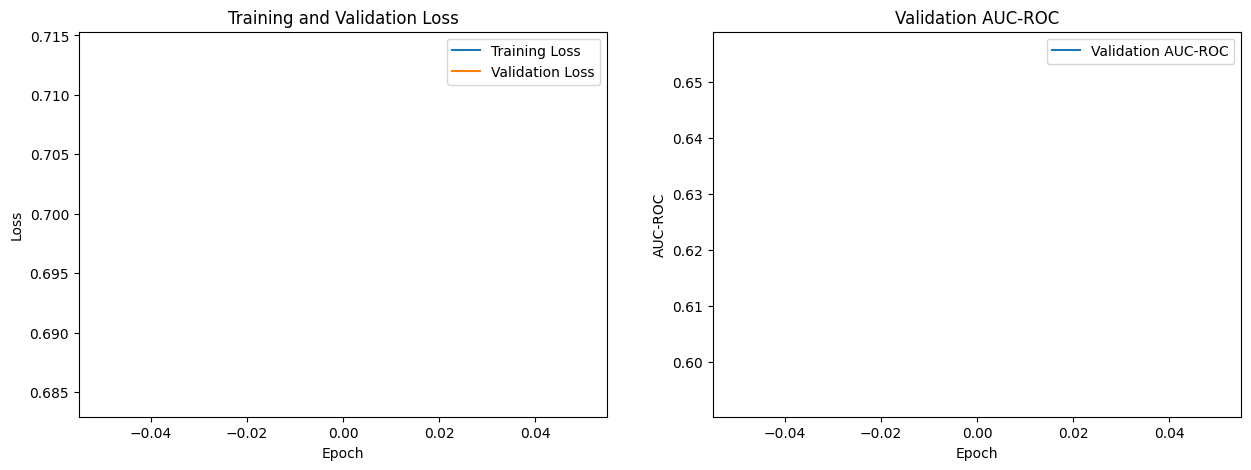

Epoch [2/16] Train Loss: 0.7189, Val Loss: 0.6872, Val AUC: 0.5880


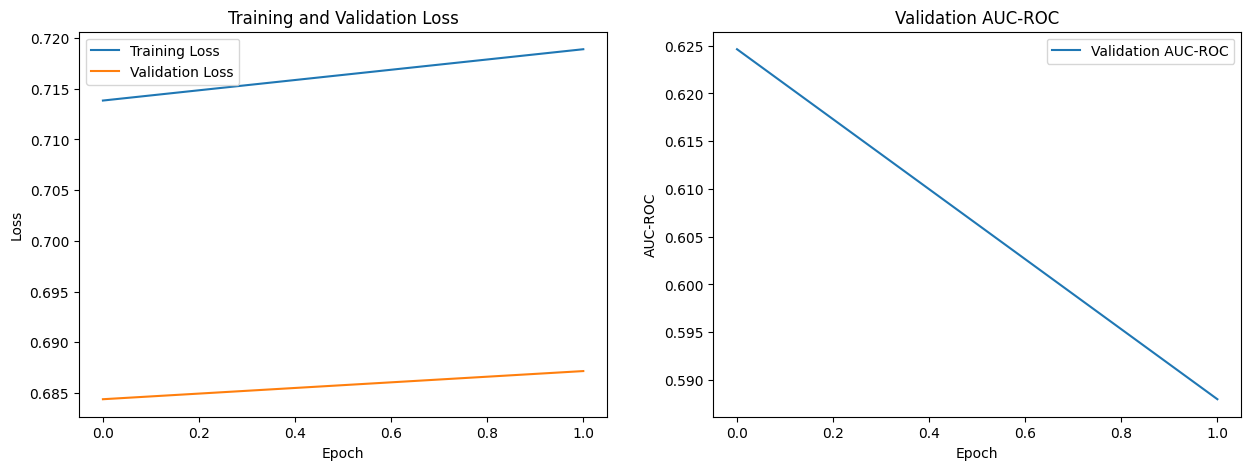

Epoch [3/16] Train Loss: 0.7010, Val Loss: 0.6849, Val AUC: 0.5853


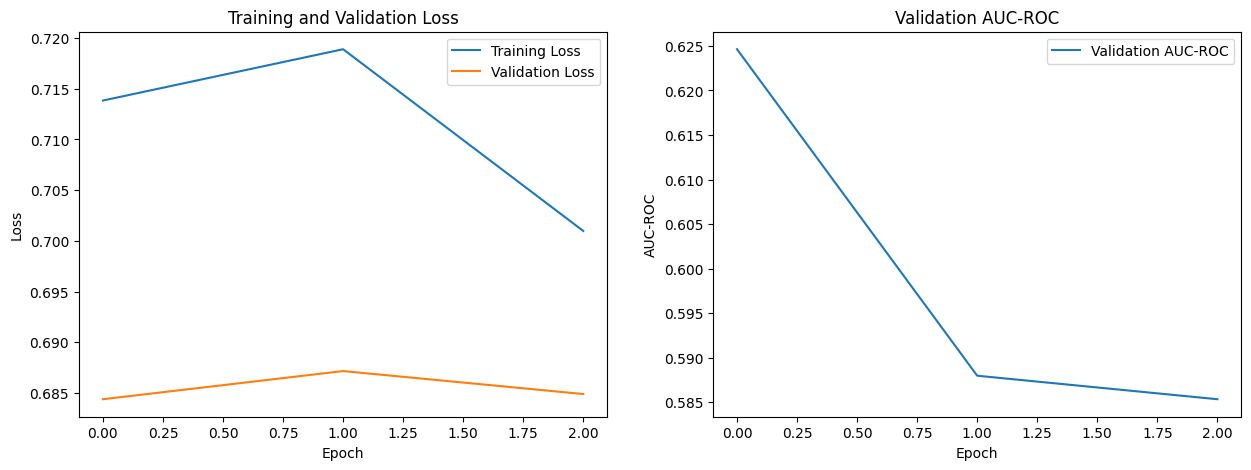

Epoch [4/16] Train Loss: 0.6961, Val Loss: 0.7005, Val AUC: 0.5962


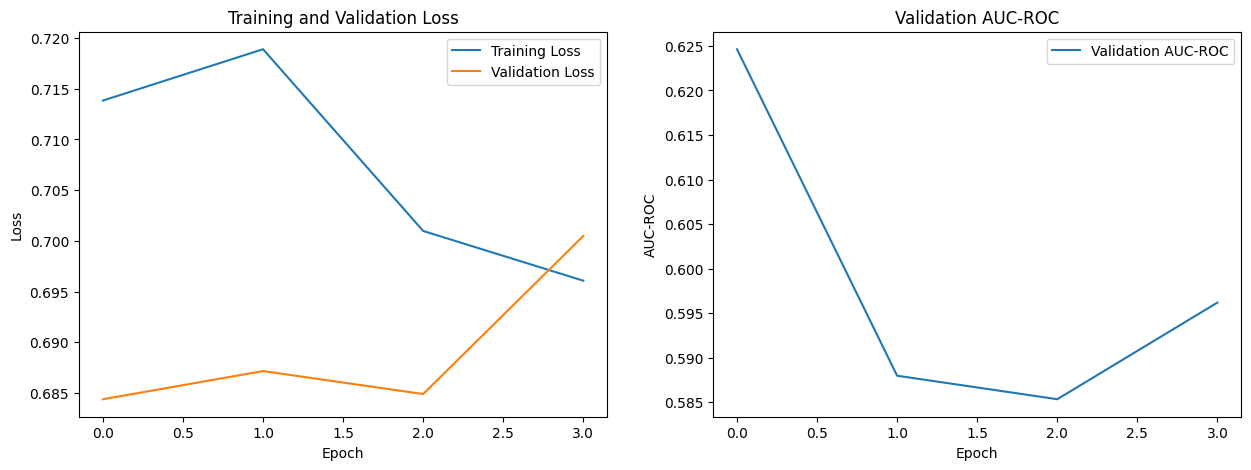

Epoch [5/16] Train Loss: 0.6892, Val Loss: 0.6903, Val AUC: 0.5842


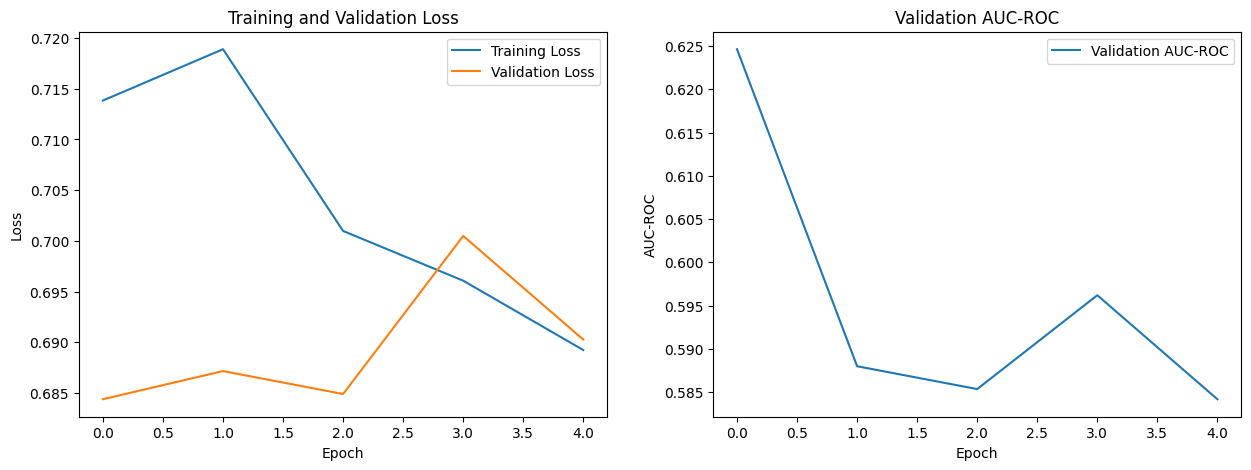

Epoch [6/16] Train Loss: 0.6934, Val Loss: 0.7294, Val AUC: 0.5082


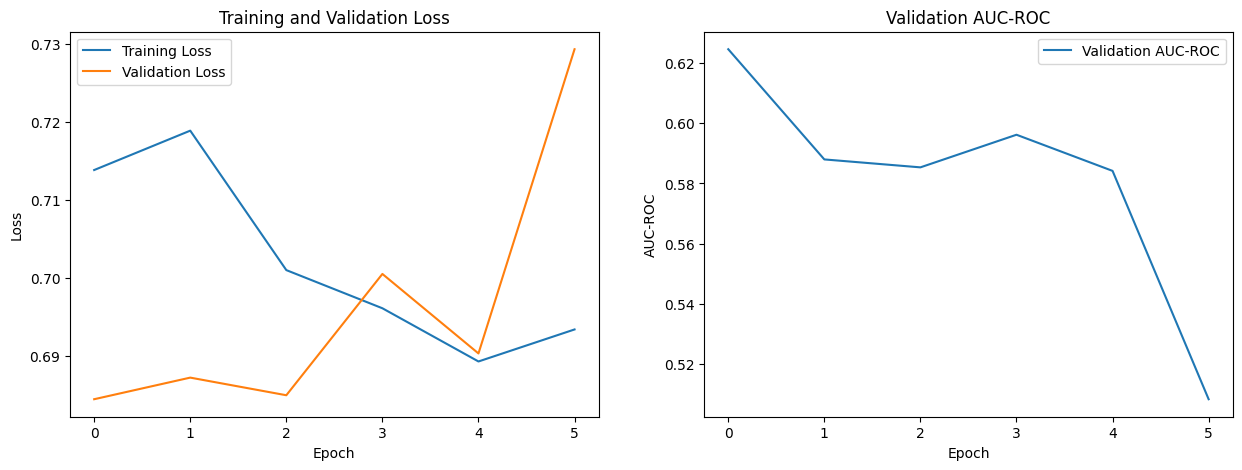

Epoch [7/16] Train Loss: 0.6936, Val Loss: 0.6978, Val AUC: 0.6029


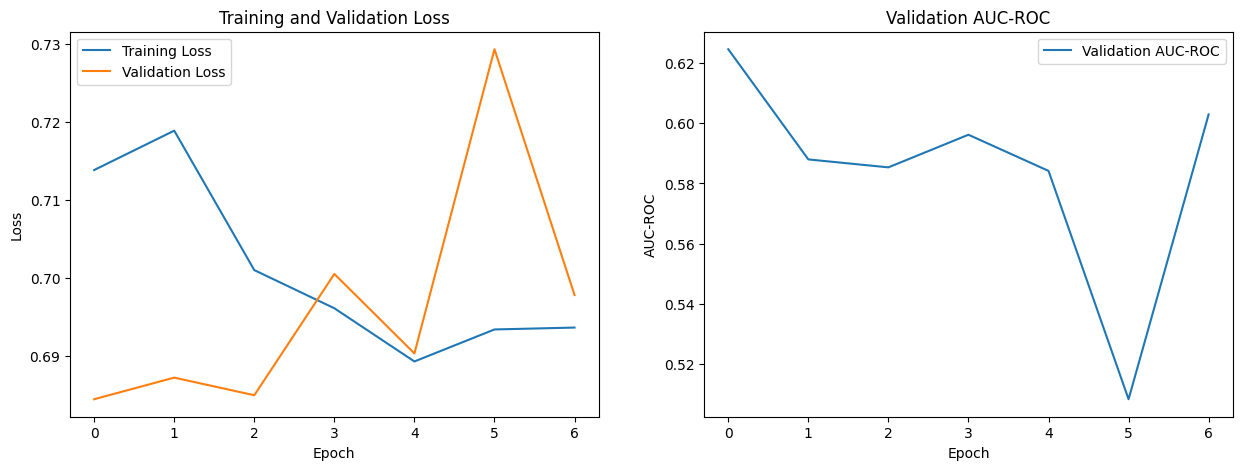

Epoch [8/16] Train Loss: 0.6907, Val Loss: 0.7116, Val AUC: 0.5751


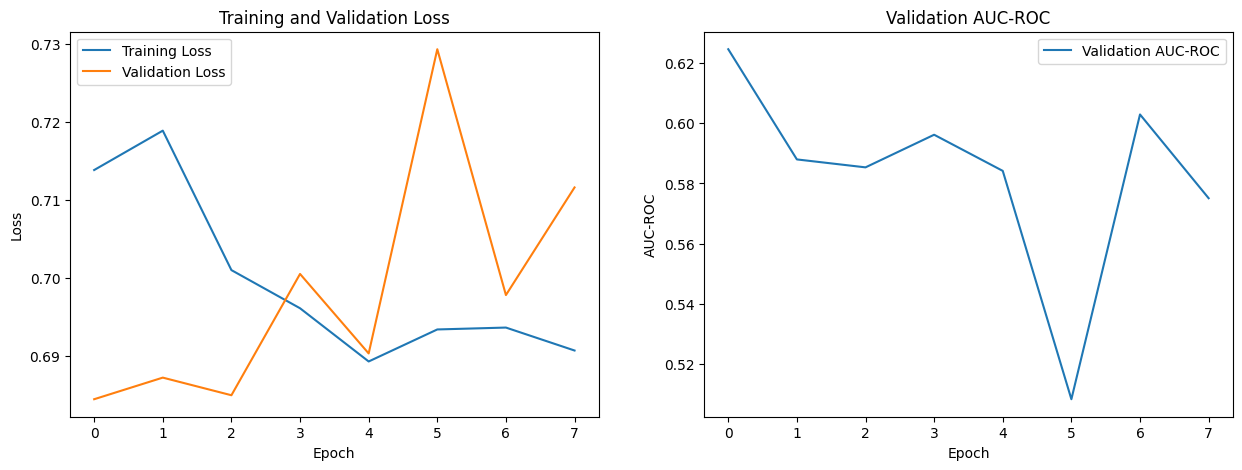

Epoch [9/16] Train Loss: 0.6908, Val Loss: 0.6749, Val AUC: 0.6082


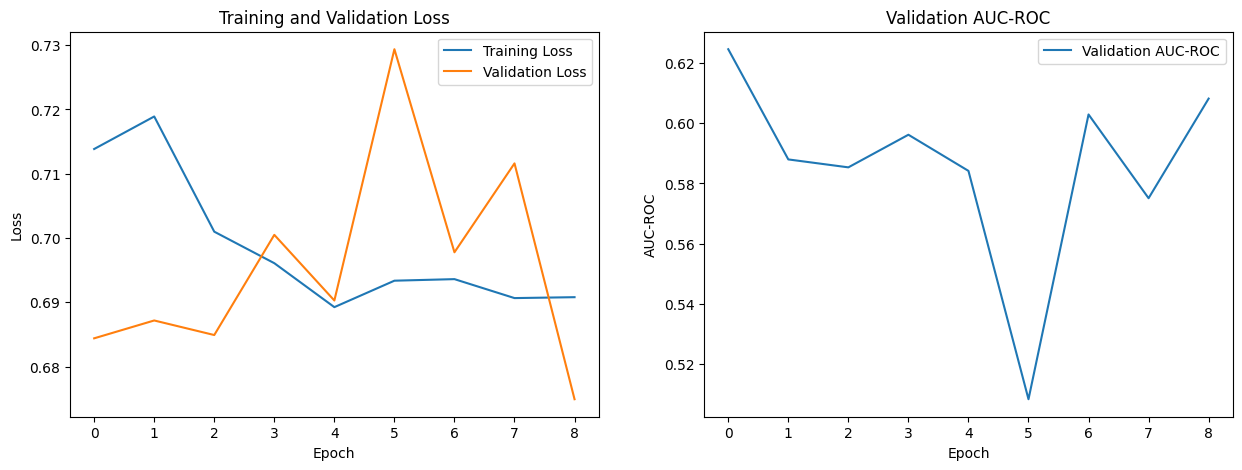

Epoch [10/16] Train Loss: 0.6892, Val Loss: 0.6858, Val AUC: 0.5592


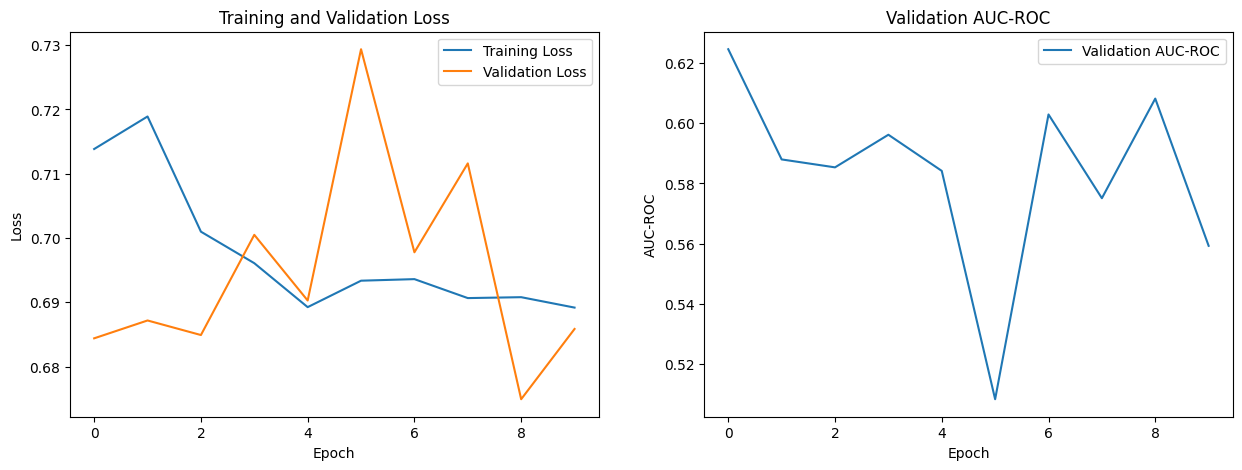

Epoch [11/16] Train Loss: 0.6857, Val Loss: 0.6836, Val AUC: 0.5686


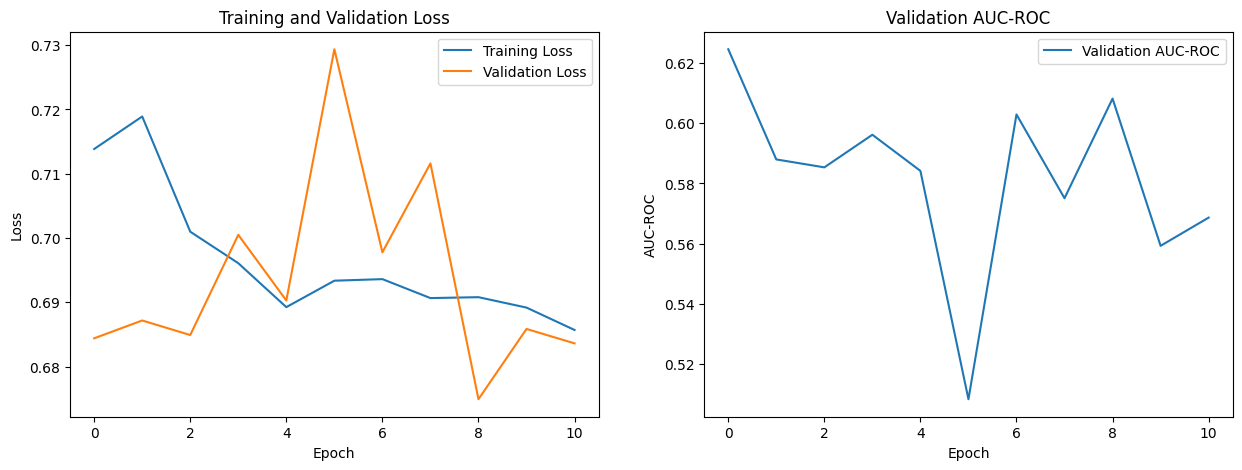

Epoch [12/16] Train Loss: 0.6788, Val Loss: 0.6980, Val AUC: 0.5545


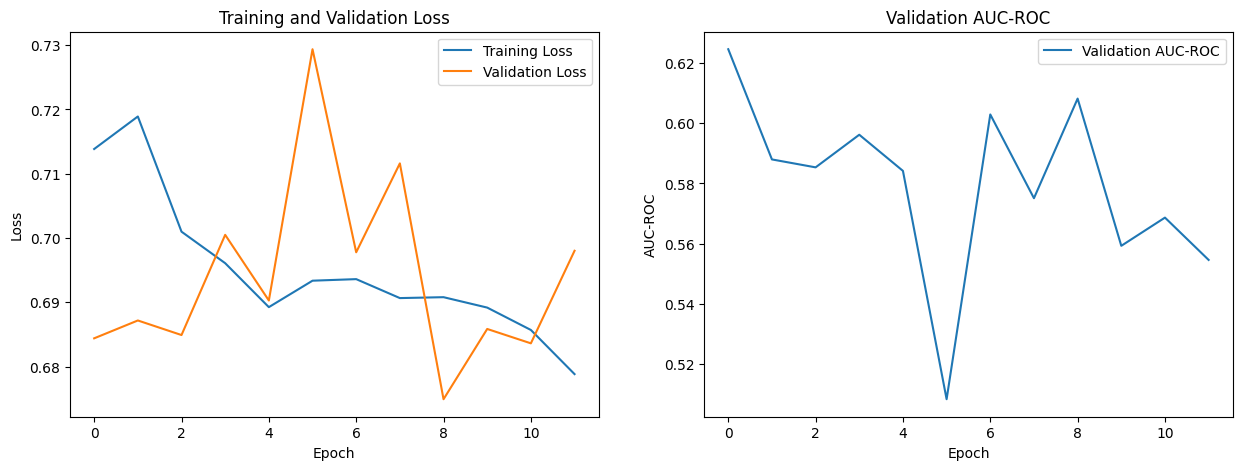

Epoch [13/16] Train Loss: 0.6837, Val Loss: 0.6933, Val AUC: 0.5528


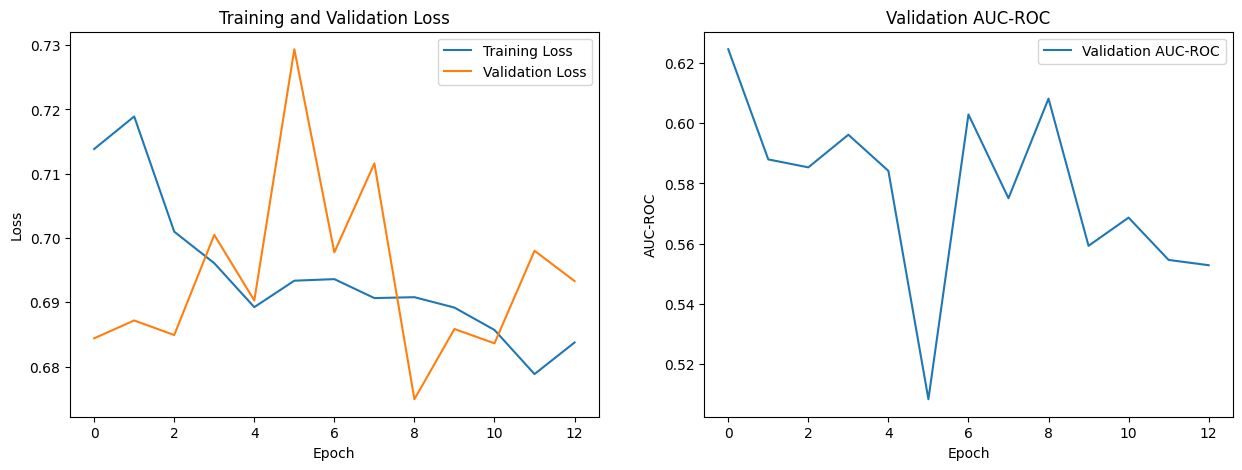

Epoch [14/16] Train Loss: 0.6880, Val Loss: 0.6837, Val AUC: 0.5713


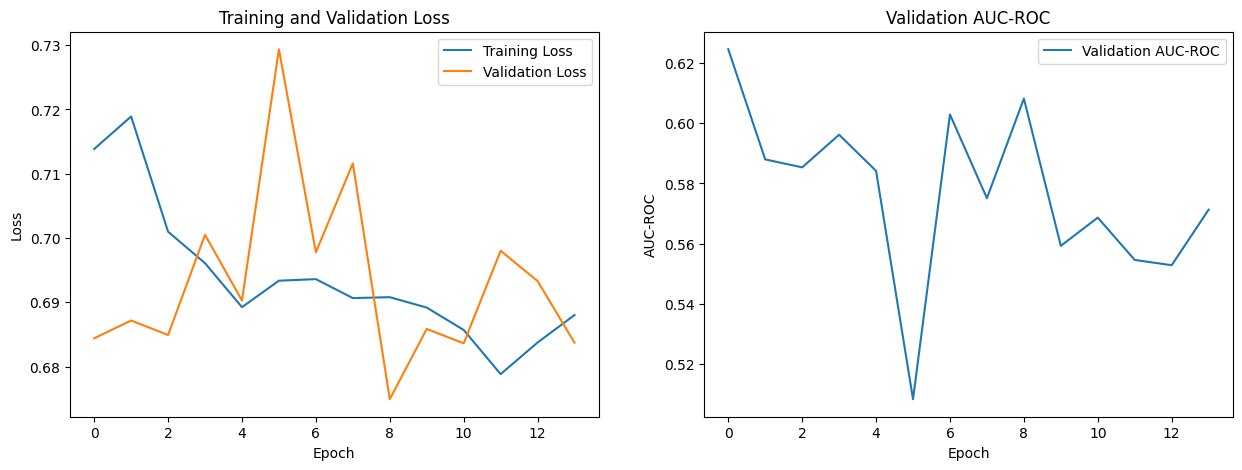

Epoch [15/16] Train Loss: 0.6891, Val Loss: 0.7251, Val AUC: 0.5589


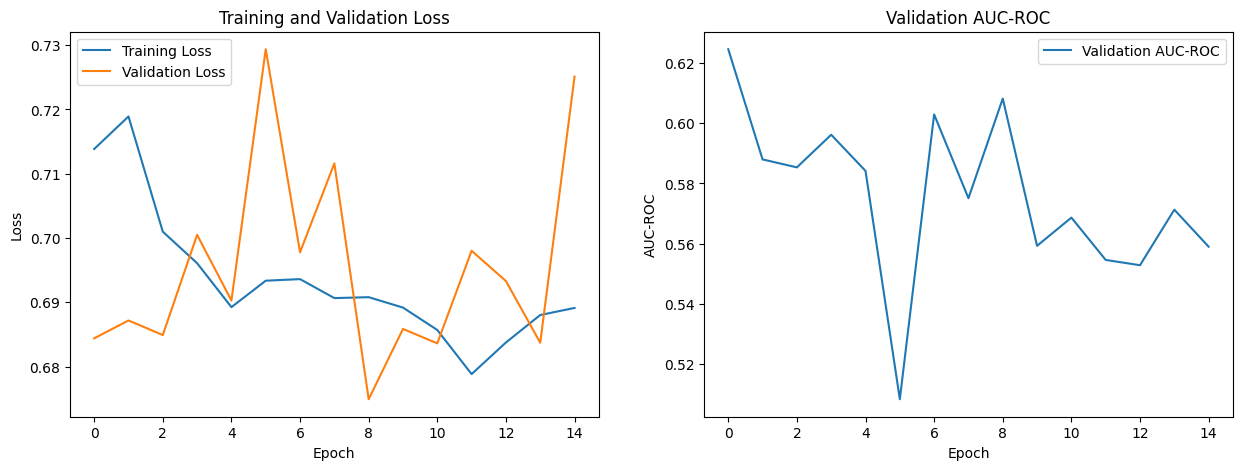

Epoch [16/16] Train Loss: 0.6704, Val Loss: 0.7505, Val AUC: 0.5921


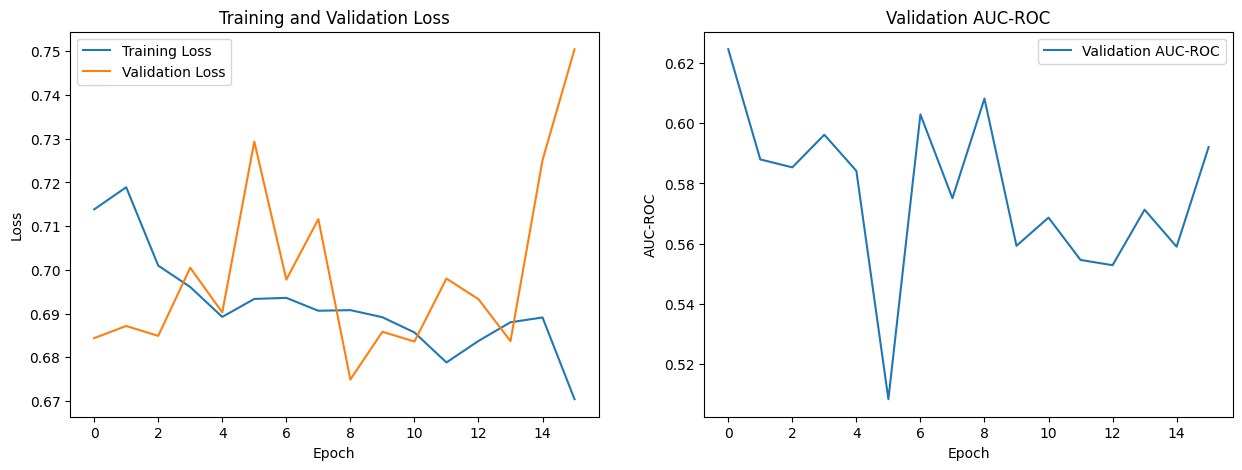

In [15]:
# Training and model definition

import monai
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from torch.optim import lr_scheduler


device = torch.device("cuda")


train_dataset =  Dataset(
    paths=df_train["BraTS21ID"].values,
    targets=df_train["MGMT_value"].values,
    mri_type=mri_types[0],
    split="train"
)

valid_dataset =  Dataset(
    paths=df_valid["BraTS21ID"].values,
    targets=df_valid["MGMT_value"].values,
    mri_type=mri_types[0],
    split="test"
)

# Loading data with torch DataLoader

train_loader = torch_data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
)

valid_loader = torch_data.DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    shuffle=False,
)

model = monai.networks.nets.resnet10(spatial_dims=3, n_input_channels=1, num_classes=1)
model.conv1.in_channels = 1
model.to(device)

#Optimizing with Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=LR_DECAY)

#model.zero_grad()
#best_loss = 9999
#best_auc = 0

#Binary Cross entropy with Logits
criterion = nn.BCEWithLogitsLoss()

#Training  and validating
#hist = train(model,train_loader,valid_loader,epochs=5)
best_auc = train(model, train_loader, valid_loader, optimizer, criterion, device, epochs=N_EPOCHS)

In [16]:
sample = pd.read_csv("../root/.cache/kagglehub/competitions/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

In [44]:
from tqdm import tqdm
from torch.utils.data import DataLoader

sample["BraTS21ID"] = sample["BraTS21ID"].astype(str).str.zfill(5)

test_dataset = Dataset(paths=sample["BraTS21ID"].values, targets=None, mri_type="FLAIR", split="test")  # targets=None for inference
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

model.load_state_dict(torch.load("/content/best_model.pth"))
model.eval()  # Set the model to evaluation mode

# Create a new column in the DataFrame to store predictions
sample["MGMT_value"] = 0.0  # Initialize with default value

# Prediction loop using DataLoader
for i, batch in enumerate(tqdm(test_loader)):
    images = batch["X"].to(device).float()
    ids = batch["id"]

    with torch.no_grad():
        outputs = model(images)
        predictions = outputs.sigmoid().detach().cpu().numpy().flatten()  # Flatten for single values

    # Store predictions in the DataFrame
    for j, prediction in enumerate(predictions):
        id_str = str(ids[j]).zfill(5)  # Convert id to string with leading zeros
        matching_rows = sample[sample["BraTS21ID"] == id_str]
        if not matching_rows.empty:
            index = matching_rows.index[0]
            sample.loc[index, "MGMT_value"] = prediction
        else:
            print(f"Warning: No matching row found for BraTS21ID: {ids[j]}")  # Optional warning message

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 11/11 [00:05<00:00,  2.03it/s]


In [45]:
sample

,BraTS21ID,MGMT_value
0,00001,0.620111
1,00013,0.638190
2,00015,0.609112
3,00027,0.578659
4,00037,0.641677
...,...,...
82,00826,0.596911
83,00829,0.508676
84,00833,0.620773
85,00997,0.691503


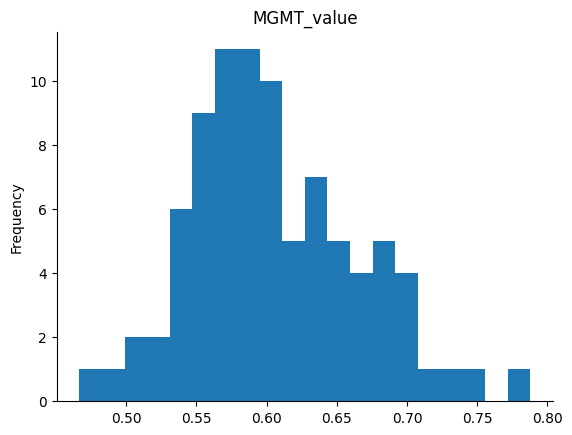

In [46]:
# @title MGMT_value

from matplotlib import pyplot as plt
sample['MGMT_value'].plot(kind='hist', bins=20, title='MGMT_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [47]:
sample.to_csv("submission.csv", index=False)